# Experiments of Toy Multi-variate Gaussian Dataset: Part II


In [ ]:
!nvidia-smi

Sun Nov 21 03:06:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
from tqdm import tqdm
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.models as models
from torchvision import datasets, transforms
from torch.autograd import Variable
import torch.utils.data as Data 
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import matplotlib.tri as tri
import plotly.graph_objects as go
import random
import copy
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

def seed_torch(seed=1029):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.enabled = False
seed_torch(1)

K_CLAS = 3                          # Number of classes in the toy dataset
N_Data = int(1e5)                   # Number of samples in the dataset
TVT_SPLIT = [0.05, 0.05, 0.9]       # Split ratio between of train/valid/test dataset
N_Train = int(N_Data*TVT_SPLIT[0])  # Number of training samples
N_Valid = int(N_Data*TVT_SPLIT[1])  # Number of validation samples
N_Test = int(N_Data*TVT_SPLIT[2])   # Number of test samples

BATCH_SIZE = 10                     # Training batch size
EPOCHS = 200                        # Number of training epochs
LR = 3e-4                           # Initial learning rate
LR_MIN = 3e-4                       # Minimum learning rate in cosine scheduler
X_DIM = 30                          # Dimension of input signal x
NOISE = 6                           # Noisy level when generating the dataset

LS_EPS = (1-0.2)                          # Eps of label smoothing, label is y*eps + u*(1-eps)/K_CLAS

MU_VEC = np.random.randint(-1,2,size=(K_CLAS,X_DIM))      # mu_1,...,mu_K
MU_VEC_ALL = np.tile(MU_VEC,(N_Data,1,1))

## Generate the mulit-variate Gaussian Dataset 

(Also refer to Appendix A in the papaer)

In this dataset, we have $N$ samples and each sample is a 3-tuple (${x},y,p^*)$. To get one sample, we first select the label $y=k$ following an uniform distribution over all $K$ classes. After that, we sample the input signal ${x}|_{y=k}\sim\mathcal{N}({\mu}_k,\sigma^2I)$, where $\sigma$ is the noisy level for all the samples. ${\mu}_k$ is the mean vector for all the samples in class $k$. Each ${\mu}_k$ is a 30-dim vector, in which each dimension is randomly selected from $\{-1,0,1\}$. Such a process is similar to selecting 30 different features for each class. Finally, we calculate the true Bayesian probability of this sample, i.e., $p^*(y|{x})$.

To calculate $p^*(y|{x})$, we use the fact that $p^*(y|{x})\propto p({x}|y)p(y)$. As $y$ follows an uniform distribution, we have $p^*(y|{x})=\frac{p({x}|y=k)}{\sum_{j\neq k}p({x}|y=j)}$. Following $p({x}|y=k)\sim\mathcal{N}({\mu}_k,\sigma^2I)$, we find $p^*(y|{x})$ should have a Softmax form, i.e., $p=\frac{\rm{e}^{s_k}}{\sum_{j\neq k}\rm{e}^{s_j}}$. Specifically, we have:

\begin{equation}
    p^*(y=k|{x})=\frac{\rm{e}^{s_k}}{\sum_{j\neq k}\rm{e}^{s_j}};\quad s_i = -\frac{1}{2\sigma^2}\|{x}-{\mu}_i\|^2_2
\end{equation}

In [ ]:
def sigmoid(x):
  return 1/(1+np.exp(-x))

def y_to_oht(label):
  label_oht = torch.zeros(label.shape[0],K_CLAS).to(label.device)
  label_oht.scatter_(1,label,1)
  label_oht = label_oht.float()
  return label_oht

def data_gen(x,y,p):
  '''
    Pack everything to a train_loader and a val_lodaer
  '''
  x, y, p = torch.tensor(x), torch.tensor(y), torch.tensor(p)
  indices = list(range(N_Data))
  train_indices, val_indices, test_indices = indices[:N_Train], indices[N_Train:N_Train+N_Valid], indices[N_Train+N_Valid:]
  idx_train = torch.tensor(np.arange(0,N_Train,1))
  idx_valid = torch.tensor(np.arange(0,N_Valid,1))
  idx_test = torch.tensor(np.arange(0,N_Test,1))

  train_dataset = Data.TensorDataset(x[train_indices],y[train_indices],p[train_indices],idx_train)
  train_loader = Data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last = True)

  valid_dataset = Data.TensorDataset(x[val_indices],y[val_indices],p[val_indices],idx_valid)
  valid_loader = Data.DataLoader(valid_dataset, batch_size=N_Valid, shuffle=True, drop_last = True)

  test_dataset = Data.TensorDataset(x[test_indices],y[test_indices],p[test_indices],idx_test)
  test_loader = Data.DataLoader(test_dataset, batch_size=N_Test, shuffle=True, drop_last = True) 

  return train_loader, valid_loader, test_loader

# =========== Generate all x, y and p===============================
y_true = np.random.randint(0,K_CLAS,[N_Data,1]).astype(np.float32)
mu_true = np.zeros((N_Data, X_DIM))
for i in range(N_Data):
  mu_true[i,:] = MU_VEC[y_true[i].astype(np.int),:]
x_true = mu_true + np.random.randn(N_Data, X_DIM)*np.sqrt(NOISE)


logits = np.zeros((N_Data,K_CLAS))
for k in range(K_CLAS):
  logits[:,k] = np.linalg.norm(x_true - MU_VEC_ALL[:,k,:], axis=1)**2*(-0.5/NOISE)
logits = torch.from_numpy(logits)
p_true = F.softmax(logits, 1)

In [ ]:
train_loader, valid_loader, test_loader = data_gen(x_true,y_true,p_true)

# Learn from Gaussian Dataset

Here we train a simple 2-layer MLP with ReLU activation. The hidden size is 128. During training, we will track these metrics:

- **loss**: the training loss of each update

(all of the following metrics are measured at the end of each epoch)

- **tacc**: accuracy on test set
- **vacc**: accuracy on validation set
- **tdistp**: L2-distance between the network's output $\mathbf{q}$ and ground truth distribution $\mathbf{p}^*$ on all training set, i.e., $\|\mathbf{q}(X_{train})-\mathbf{p}^*(X_{train})\|_2$
- **vdistp**: similar to tdistp, but on validation set
- **tdisttgt**: L2-distance between network's output and the supervision it trained on, i.e., $\|\mathbf{q}(X_{train})-\mathbf{p}_{tgt}^*(X_{train})\|_2$
- **vdisttgt**: similar to tdisttgt, but on validation set
- **tECE**: the expected calibration error of network's output on test set, refer to the appendix of the paper for more details
- **vECE**: ECE on validation set
- **L2_p_np**: the L2-distance between the ground truth distribution and its noisy version (later we will let the network directly learn under the supervision of a noisy-p)
- **IDX_MAX**: the number of the best epoch based on validation accuracy

Finally, we also report the **acc, tdistp, ECE** on test set for each model.

In [ ]:
def cal_ECE(pb_table, tf_table):
  '''
    pb_table is the probability provided by network
    tf_table is the acc results of the prodiction
  '''
  BM_acc = np.zeros((K_CLAS,))
  BM_conf = np.zeros((K_CLAS,))
  BM_cnt = np.zeros((K_CLAS,))
  Index_table = (pb_table.T*K_CLAS-1e-6).int().squeeze()

  for i in range(pb_table.shape[0]):
    idx = Index_table[i]
    BM_cnt[idx] += 1
    BM_conf[idx] += pb_table[i]
    if tf_table[i]:
      BM_acc[idx] += 1
  ECE = 0
  for j in range(K_CLAS):
    if BM_cnt[j] != 0:
      ECE += BM_cnt[j]*np.abs(BM_acc[j]/BM_cnt[j]-BM_conf[j]/BM_cnt[j])
  return ECE/BM_cnt.sum()

def L2_distance_logits_p(logits, p):
  return nn.PairwiseDistance(p=2.0, eps=1e-12, keepdim=False)(F.softmax(logits,1),p).detach().mean()
  #return nn.MSELoss(reduce=False)(F.softmax(logits,1),p).detach()

def L2_distance_q_p(q, p):
  return  nn.PairwiseDistance(p=2.0, eps=1e-12, keepdim=False)(q,p).detach().mean()
  #return nn.MSELoss(reduce=False)(q,p).detach()

def cal_entropy(logits, p):
  # logits is the output of the network
  # p is the true probability (e.g. true probability)
  return nn.KLDivLoss(reduction='batchmean')(F.log_softmax(logits,1), p)

def _y_to_oht(label):
  label_oht = torch.zeros(label.shape[0],K_CLAS).to(label.device)
  label_oht.scatter_(1,label,1)
  label_oht = label_oht.float()
  return label_oht

def _y_to_smoothed(y):
  y_oht = _y_to_oht(y)
  return y_oht*LS_EPS + torch.ones_like(y_oht)*(1-LS_EPS)/K_CLAS

class MLP(nn.Module):
  def __init__(self, in_dim, hid_size=128):
    super(MLP, self).__init__()
    self.in_dim = in_dim
    self.hid_size = hid_size    
    self.fc1 = nn.Linear(self.in_dim, self.hid_size)
    self.fc2 = nn.Linear(self.hid_size, self.hid_size)
    self.fc3 = nn.Linear(self.hid_size, K_CLAS)
    self.act = nn.ReLU(True)

  def forward(self, x):
    h1 = self.act(self.fc1(x))
    h2 = self.act(self.fc2(h1))
    out = self.fc3(h2)
    return out

Function of saving learning path of each sample.

In [ ]:
PATH_DICT_TRAIN = np.zeros((N_Train,EPOCHS+1,K_CLAS))
PATH_DICT_VALID = np.zeros((N_Valid,EPOCHS+1,K_CLAS))

def _Record_Path(pred_batch, idx_batch, epoch, train_or_valid='train'):
  pred_items = pred_batch.cpu().detach()
  batch_size = idx_batch.shape[0]
  if train_or_valid=='train':
    for i in range(batch_size):
      idx_key = idx_batch[i].item()
      tmp_pred = pred_items[i]
      PATH_DICT_TRAIN[idx_key, epoch,:]=tmp_pred
  elif train_or_valid=='valid':
    for i in range(batch_size):
      idx_key = idx_batch[i].item()
      tmp_pred = pred_items[i]
      PATH_DICT_VALID[idx_key, epoch,:]=tmp_pred
  else:
    print('!!!!! Record_Path must input train or valid !!!!!')

In [ ]:
def eval_model_on_test(model):
  model.eval()
  for x,y,p, _ in test_loader:
    x,y,p = x.float().cuda(), y.long(), p.float()
    break
  hid = model(x)
  hid = hid.cpu().detach()
  pred = hid.data.max(1, keepdim=True)[1]
  prob_table = torch.gather(nn.Softmax(1)(hid),dim=1,index=pred)
  tf_table = pred.eq(y.data.view_as(pred))
  acc = tf_table.sum()/N_Test
  dist = L2_distance_logits_p(hid, p)
  ECE = cal_ECE(prob_table,tf_table)
  model.train()
  return acc, dist, ECE

def get_validation(model, epoch, train_or_valid='train', loss_type='from_oht', teacher=None):
  if train_or_valid.lower()=='train':
    data_loader = train_loader
  elif train_or_valid.lower()=='valid':
    data_loader = valid_loader
  batch_size = data_loader.batch_size
  model.eval()
  correct = 0
  dist_p,dist_tgt = 0, 0
  pb_table, tf_table = [], []
  hid_all, p_all, p_tgt_all = [], [], []
  b_cnt = 0
  for x, y, p, idx in data_loader:
    b_cnt += 1
    x,y,p = x.float().cuda(), y.long(), p.float()
    with torch.no_grad():
      hid = model(x)
      hid = hid.cpu().detach()
      pred_batch = F.softmax(hid,1)
      _Record_Path(pred_batch, idx, epoch, train_or_valid)
      pred = hid.data.max(1, keepdim=True)[1] # get the index of the max log-probability
      prob = torch.gather(nn.Softmax(1)(hid),dim=1,index=pred)
      y_oht=y_to_oht(y.long())
      pb_table.append(prob)
      tf_table.append(pred.eq(y.data.view_as(pred)))     

      if loss_type == 'from_oht':
        p_tgt = _y_to_oht(y)
      elif loss_type == 'from_ls':
        p_tgt = _y_to_smoothed(y)
      elif loss_type == 'from_gt' or loss_type == 'noise_prob':
        p_tgt = p
      elif loss_type == 'from_teacher':              
        teacher.eval()
        hid_teach = teacher(x)
        hid_teach = hid_teach.cpu().detach()
        p_tgt = F.softmax(hid_teach,1)
      p_all.append(p)
      hid_all.append(hid)
      p_tgt_all.append(p_tgt)
  model.train()
  pb_table = torch.stack(pb_table).reshape(-1,1)
  tf_table = torch.stack(tf_table).reshape(-1,1)
  ECE = cal_ECE(pb_table, tf_table)
  B_NUM = batch_size*b_cnt
  correct = tf_table.sum()

  hid_all = torch.stack(hid_all).reshape(-1,K_CLAS)
  p_all = torch.stack(p_all).reshape(-1,K_CLAS)
  p_tgt_all = torch.stack(p_tgt_all).reshape(-1,K_CLAS)
  dist_p = L2_distance_logits_p(hid_all, p_all)
  dist_tgt = L2_distance_logits_p(hid_all, p_tgt_all)
  return correct/B_NUM, dist_p, dist_tgt, ECE

def train(model, optimizer, scheduler, loss_type='from_oht', teacher=None, prt_flag=False, p_noise=0, noisy_type='combine'):
  results = {'loss':[], 'tacc':[], 'vacc':[], 'tdistp':[],'vdistp':[],'tdisttgt':[],'vdisttgt':[],'tECE':[],'vECE':[],'L2_ptgt_pgt':[],'IDX_MAX':[]}
  vacc_max = 0
  model.train()
  if teacher!=None:
    teacher=teacher.cuda()
  p_list, p_tgt_list = [], []
  tacc, tdistp, tdisttgt, tECE = get_validation(model, 0, 'train', loss_type=loss_type, teacher=teacher)
  vacc, vdistp, vdisttgt, vECE = get_validation(model, 0, 'valid', loss_type=loss_type, teacher=teacher)
  for g in range(EPOCHS):
    for x,y,p,idx in train_loader:
      x,y,p = x.float().cuda(), y.long().cuda(), p.float().cuda()
      optimizer.zero_grad()
      hid = model(x)

      if loss_type == 'from_oht':
        p_tgt = _y_to_oht(y)
      elif loss_type == 'from_ls':
        p_tgt = _y_to_smoothed(y)
      elif loss_type == 'from_gt':
        p_tgt = p
      elif loss_type == 'from_teacher':
        teacher.eval()
        hid_teach = teacher(x)
        hid_teach = hid_teach.detach()
        p_tgt = F.softmax(hid_teach,1)
      elif loss_type == 'noise_prob':
        if noisy_type=='combine':
          p_tgt = _y_to_oht(y)*p_noise[0] + p*(1-p_noise[0])
        elif noisy_type=='plus':
          noisy_p = p + torch.from_numpy(np.random.randn(p.shape[0],p.shape[1])*np.sqrt(p_noise)).cuda()
          noisy_p = torch.clamp(noisy_p,min=1e-6,max=2)
          noisy_p = noisy_p/noisy_p.sum(1).expand([K_CLAS,-1]).transpose(0,1)
          p_tgt = noisy_p.float()          
      if g==0:          # Only calculate L2_ptgt_pgt once
        p_list.append(p)
        p_tgt_list.append(p_tgt)
      loss = cal_entropy(hid, p_tgt)
      loss.backward()
      optimizer.step()
      results['loss'].append(loss.item())
    # ---------- At the end of each epoch ----------
    tacc, tdistp, tdisttgt, tECE = get_validation(model, g+1, 'train', loss_type=loss_type, teacher=teacher)
    vacc, vdistp, vdisttgt, vECE = get_validation(model, g+1, 'valid', loss_type=loss_type, teacher=teacher)
    results['tacc'].append(tacc)
    results['vacc'].append(vacc)
    results['tdistp'].append(tdistp)
    results['vdistp'].append(vdistp)
    results['tdisttgt'].append(tdisttgt)
    results['vdisttgt'].append(vdisttgt)
    results['tECE'].append(tECE)
    results['vECE'].append(vECE)
    if vacc>vacc_max:
      vacc_max = vacc
      ES_model = copy.deepcopy(model)
      results['IDX_MAX']=g
    if prt_flag and g%10==0:
      print('\t==Training , Epoch: {:3d}/{:3d}\tLoss: {:.6f}\tTACC: {:.6f},\tVACC:{:.6f}'.format(g,EPOCHS, results['loss'][-1], tacc, vacc))
    #scheduler.step()
  results['L2_ptgt_pgt'] = L2_distance_q_p(torch.stack(p_list).reshape(-1,K_CLAS), torch.stack(p_tgt_list).reshape(-1,K_CLAS)).cpu()
  return ES_model, results

In [ ]:
OHT_model = MLP(in_dim=X_DIM).cuda()
Init_model = copy.deepcopy(OHT_model)
OHT_optimizer = optim.SGD(OHT_model.parameters(), lr=LR, momentum=0.9)
OHT_scheduler = optim.lr_scheduler.CosineAnnealingLR(OHT_optimizer, T_max=EPOCHS, eta_min=LR_MIN)
best_OHT_model, OHT_results = train(OHT_model, OHT_optimizer, OHT_scheduler, 'from_oht',prt_flag=True)

	==Training , Epoch:   0/200	Loss: 0.437769	TACC: 0.804200,	VACC:0.795400
	==Training , Epoch:  10/200	Loss: 0.106150	TACC: 0.864800,	VACC:0.839000
	==Training , Epoch:  20/200	Loss: 0.187777	TACC: 0.878600,	VACC:0.836800
	==Training , Epoch:  30/200	Loss: 0.197725	TACC: 0.894400,	VACC:0.831800
	==Training , Epoch:  40/200	Loss: 0.181431	TACC: 0.911200,	VACC:0.826000
	==Training , Epoch:  50/200	Loss: 0.134194	TACC: 0.926800,	VACC:0.821400
	==Training , Epoch:  60/200	Loss: 0.139483	TACC: 0.942800,	VACC:0.816800
	==Training , Epoch:  70/200	Loss: 0.016434	TACC: 0.957200,	VACC:0.813400
	==Training , Epoch:  80/200	Loss: 0.064328	TACC: 0.969800,	VACC:0.804800
	==Training , Epoch:  90/200	Loss: 0.045405	TACC: 0.979400,	VACC:0.800800
	==Training , Epoch: 100/200	Loss: 0.032248	TACC: 0.990400,	VACC:0.797800
	==Training , Epoch: 110/200	Loss: 0.118308	TACC: 0.996800,	VACC:0.797600
	==Training , Epoch: 120/200	Loss: 0.106639	TACC: 0.997800,	VACC:0.798800
	==Training , Epoch: 130/200	Loss: 0.0

# Difficulty of the training and validation samples

In ESKD, we know $\|\mathbf{p}_\text{tar}-\mathbf{p}^*\|_2^2=\frac{1}{N}\sum_{i=1}^N({p}_\text{tar}(x_i)-{p}^*(x_i))^2$. We guess some examples are 'hard' because they can offer larger discrepancy in the above expression. Here we want give a difficulty score to each example based on $({p}_\text{tar}(x_i)-{p}^*(x_i))^2$, and at the same time, we want to see whether the following 3 metrics can represent the difficulty well:

- **Base metric**, distance between OHT label and true distribution: $(\mathbf{e}_y(x_i)-{p}^*(x_i))^2$
- **Integral**, intergral of the learning curve of the correct prediction: $\frac{1}{T}\sum_t^{T} q_t(y=k_i|x_i)$
- **Converged**, converged probability of the correct prediction: $q_\text{T}(y=k_i|x_i)$

In [ ]:
def get_hardness_metric(model=None, train=True, metric_type='oht_true'):
  if model!=None:
    model = model.cpu()
  if train:
    data_loader = train_loader
    N_sample = N_Train
    PATH = PATH_DICT_TRAIN
  else:
    data_loader = valid_loader
    N_sample = N_Valid
    PATH = PATH_DICT_VALID
  hardness_table = np.zeros((N_sample,2))
  for x,y,p,idx in data_loader:
    x,y = x.float(), y.long()
    if metric_type=='oht_true':
      y_oht = _y_to_oht(y)
      distance = nn.PairwiseDistance(p=2.0, eps=1e-12, keepdim=False)(p,y_oht)
    elif metric_type=='lslabel_true':
      y_smooth = _y_to_smoothed(y)
      distance = nn.PairwiseDistance(p=2.0, eps=1e-12, keepdim=False)(p,y_smooth).detach()
    elif metric_type=='integral':
      distance = _integral_distance(PATH[idx], y)
    elif metric_type=='converged':
      distance = _converged_distance(PATH[idx], y)
    elif metric_type=='model_true':
      hid = model(x)
      pred = F.softmax(hid,1)
      distance = nn.PairwiseDistance(p=2.0, eps=1e-12, keepdim=False)(p,pred).detach()

    hardness_table[idx,0] = idx
    hardness_table[idx,1] = distance
  hardness_table_df = pd.DataFrame(hardness_table,columns=['index','hardness'])
  hardness_table_sorted = hardness_table_df.sort_values('hardness',ascending=False)
  return hardness_table_sorted

def _integral_distance(SUB_PATH,y):
  N = y.shape[0]
  distance = np.zeros((N,))
  SUM_SUB_PATH = SUB_PATH.sum(1)
  for i in range(N):
    corr_idx = int(y[i])
    distance[i] = SUM_SUB_PATH[i,corr_idx]
  return distance

def _converged_distance(SUB_PATH, y):
  N = y.shape[0]
  distance = np.zeros((N,))
  LAST_SUB_PATH = SUB_PATH[:,-1,:]
  for i in range(N):
    corr_idx = int(y[i])
    distance[i] = LAST_SUB_PATH[i,corr_idx]
  return distance

In [ ]:
oht_true_train = get_hardness_metric(None,True,'oht_true')
oht_true_valid = get_hardness_metric(None,False,'oht_true')

lslabel_true_train = get_hardness_metric(None,True,'lslabel_true')
lslabel_true_valid = get_hardness_metric(None,False,'lslabel_true')

integral_train = get_hardness_metric(None,True,'integral')
integral_valid = get_hardness_metric(None,False,'integral')

converged_train = get_hardness_metric(None,True,'converged')
converged_valid = get_hardness_metric(None,False,'converged')


Compare intergral difficulty and converged difficulty, we see integral difficulty shows better linear trend. We also propose zig-zag score (in appendix) to measure how zig-zag the path is.

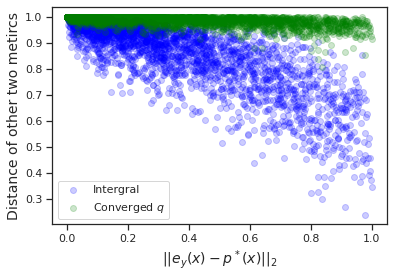

In [ ]:
hardness_x = oht_true_train.sort_values('index',ascending=True)['hardness']
hardness_y1 = integral_train.sort_values('index',ascending=True)['hardness']
hardness_y2 = converged_train.sort_values('index',ascending=True)['hardness']
plt.scatter(hardness_x/hardness_x.max(), hardness_y1/hardness_y1.max(),color='blue',alpha=0.2,label='Intergral')
plt.scatter(hardness_x/hardness_x.max(), hardness_y2/hardness_y2.max(),color='green',alpha=0.2,label='Converged $q$')
plt.legend()
plt.xlabel('$||e_{y}(x)-p^*(x)||_2$',fontsize=14)
plt.ylabel('Distance of other two metircs', fontsize=14)

# Distance gap of each training sample under different supervisions
Here we provide illustration about the distance gap, i.e., $\|q(x)-p^*(x)\|_2$ of each training sample. In the figure, the training samples might ordered by their base-difficulity. We show three differnet stages during training:

- At the beginning of training
- The early stopped point of training
- The convergence of training

Also, we consider the following 5 different supervisions, i.e., one-hot label, LS, KD, ESKD, ground truth.

The procedure of the experiment is like this: with the know base-difficulity calculated in the previous experiment, here we only need to calculate $\|q(x)-p^*(x)\|_2$. During training, we take a copy of the network of specific time and run the *get_hardness_metric* function.

## Part 1: one-hot supervision

In [ ]:
init_OHT_train = get_hardness_metric(Init_model,True,'model_true')
early_OHT_train = get_hardness_metric(best_OHT_model,True,'model_true')
converge_OHT_train = get_hardness_metric(OHT_model,True,'model_true')

hardness_y0 = init_OHT_train.sort_values('index',ascending=True)['hardness']
hardness_y1 = early_OHT_train.sort_values('index',ascending=True)['hardness']
hardness_y2 = converge_OHT_train.sort_values('index',ascending=True)['hardness']

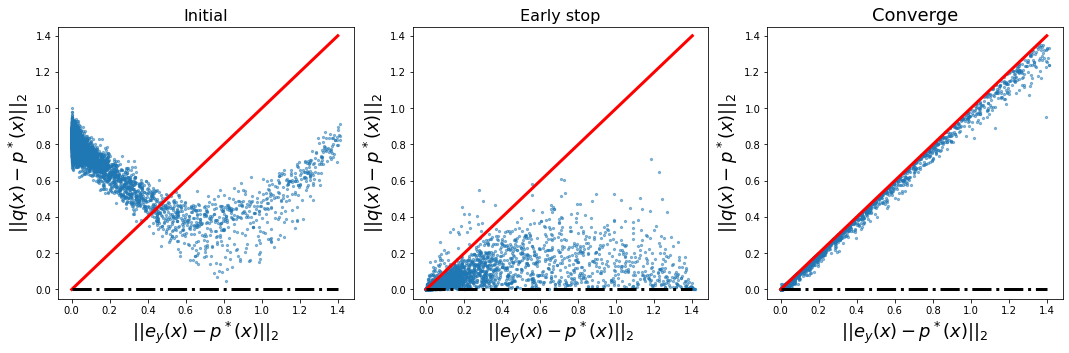

In [ ]:
figure, ax = plt.subplots(1,3,figsize=(18,5))
ax[0].scatter(hardness_x, hardness_y0,s=5,alpha=0.5)
ax[0].set_ylim(-0.05,1.45)
ax[0].plot([0,1.4],[0,1.4],'r-',linewidth=3,label='OHT')
ax[0].plot([0,1.4],[0,0],'k-.',linewidth=3,label='GT')
ax[0].set_title('Initial',fontsize=16)
ax[1].scatter(hardness_x, hardness_y1,s=5,alpha=0.5)
ax[1].set_ylim(-0.05,1.45)
ax[1].plot([0,1.4],[0,1.4],'r-',linewidth=3,label='ESKD')
ax[1].plot([0,1.4],[0,0],'k-.',linewidth=3,label='GT')
ax[1].set_title('Early stop',fontsize=16)
ax[2].scatter(hardness_x, hardness_y2,s=5,alpha=0.5)
ax[2].set_ylim(-0.05,1.45)
ax[2].plot([0,1.4],[0,1.4],'r-',linewidth=3,label='KD')
ax[2].plot([0,1.4],[0,0],'k-.',linewidth=3,label='GT')
ax[2].set_title('Converge',fontsize=18)

for i in range(3):
  ax[i].set_ylabel('$||q(x)-p^*(x)||_2$',fontsize=18)
  ax[i].set_xlabel('$||e_{y}(x)-p^*(x)||_2$',fontsize=18)

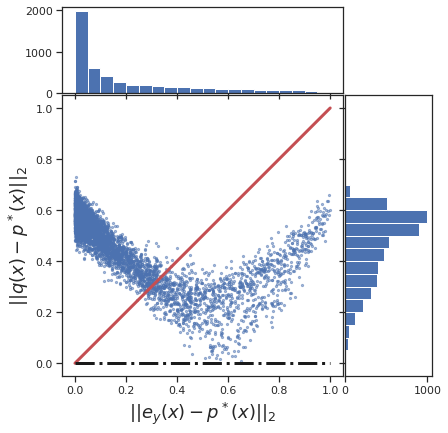

In [ ]:
def scatter_hist(x, y, ax, ax_histx, ax_histy):
  # no labels
  ax_histx.tick_params(axis="x", labelbottom=False)
  ax_histy.tick_params(axis="y", labelleft=False)
  # the scatter plot:
  ax.scatter(x,y,s=5,alpha=0.5)
  # now determine nice limits by hand:
  binwidth = 0.25
  bins = np.arange(0, 1, 0.05)
  ax_histx.hist(x, bins=bins)
  ax_histy.hist(y, bins=bins, orientation='horizontal')
  ax.set_ylabel('$||q(x)-p^*(x)||_2$',fontsize=18)
  ax.set_xlabel('$||e_{y}(x)-p^*(x)||_2$',fontsize=18)
  ax.plot([0,1],[0,1],'r-',linewidth=3,label='OHT')
  ax.plot([0,1],[0,0],'k-.',linewidth=3,label='GT')

left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure
fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)
# use the previously defined function
scatter_hist(hardness_x/np.sqrt(2), hardness_y0/np.sqrt(2), ax, ax_histx, ax_histy)
plt.tight_layout()

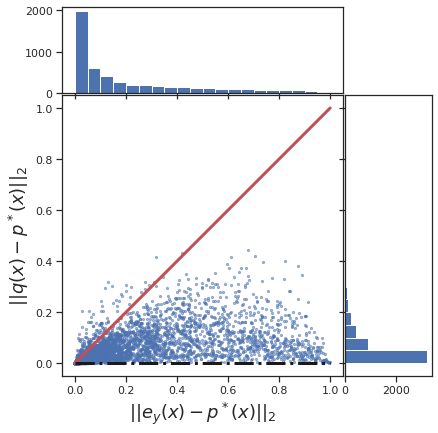

In [ ]:
# start with a square Figure
fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)
# use the previously defined function
scatter_hist(hardness_x/np.sqrt(2), hardness_y1/np.sqrt(2), ax, ax_histx, ax_histy)
plt.tight_layout()

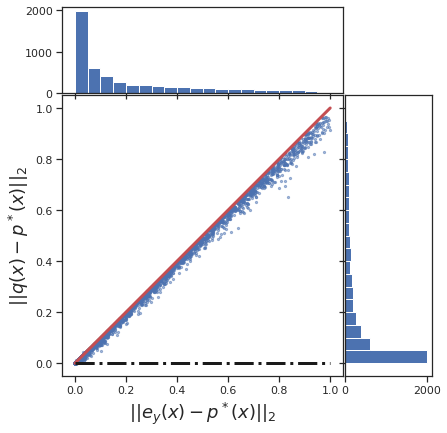

In [ ]:
# start with a square Figure
fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes(rect_scatter)
ax_histx = fig.add_axes(rect_histx, sharex=ax)
ax_histy = fig.add_axes(rect_histy, sharey=ax)
# use the previously defined function
scatter_hist(hardness_x/np.sqrt(2), hardness_y2/np.sqrt(2), ax, ax_histx, ax_histy)
plt.tight_layout()

## Part 2: other supervisions

In [ ]:
LS_model = MLP(in_dim=X_DIM).cuda()
Init_LS_model = copy.deepcopy(LS_model)
LS_optimizer = optim.SGD(LS_model.parameters(), lr=LR, momentum=0.9)
LS_scheduler = optim.lr_scheduler.CosineAnnealingLR(LS_optimizer, T_max=EPOCHS, eta_min=LR_MIN)
best_LS_model, LS_results = train(LS_model, LS_optimizer, LS_scheduler, 'from_ls',prt_flag=True)

	==Training , Epoch:   0/200	Loss: 0.337877	TACC: 0.869400,	VACC:0.864200
	==Training , Epoch:  10/200	Loss: 0.162651	TACC: 0.915400,	VACC:0.902000
	==Training , Epoch:  20/200	Loss: 0.192166	TACC: 0.922600,	VACC:0.902800
	==Training , Epoch:  30/200	Loss: 0.083041	TACC: 0.927800,	VACC:0.901600
	==Training , Epoch:  40/200	Loss: 0.125486	TACC: 0.933000,	VACC:0.903000
	==Training , Epoch:  50/200	Loss: 0.109282	TACC: 0.935600,	VACC:0.903200
	==Training , Epoch:  60/200	Loss: 0.101056	TACC: 0.938000,	VACC:0.902200
	==Training , Epoch:  70/200	Loss: 0.058943	TACC: 0.940400,	VACC:0.902200
	==Training , Epoch:  80/200	Loss: 0.020592	TACC: 0.945800,	VACC:0.901600
	==Training , Epoch:  90/200	Loss: 0.186462	TACC: 0.948000,	VACC:0.901000
	==Training , Epoch: 100/200	Loss: 0.056247	TACC: 0.955000,	VACC:0.901200
	==Training , Epoch: 110/200	Loss: 0.072462	TACC: 0.958800,	VACC:0.899400
	==Training , Epoch: 120/200	Loss: 0.074162	TACC: 0.961800,	VACC:0.899000
	==Training , Epoch: 130/200	Loss: 0.0

In [ ]:
init_LS_train = get_hardness_metric(Init_LS_model,True,'model_true')
early_LS_train = get_hardness_metric(best_LS_model,True,'model_true')
converge_LS_train = get_hardness_metric(LS_model,True,'model_true')

hardness_LS_label = lslabel_true_train.sort_values('index',ascending=True)['hardness']

hardness_LS_y0 = init_LS_train.sort_values('index',ascending=True)['hardness']
hardness_LS_y1 = early_LS_train.sort_values('index',ascending=True)['hardness']
hardness_LS_y2 = converge_LS_train.sort_values('index',ascending=True)['hardness']

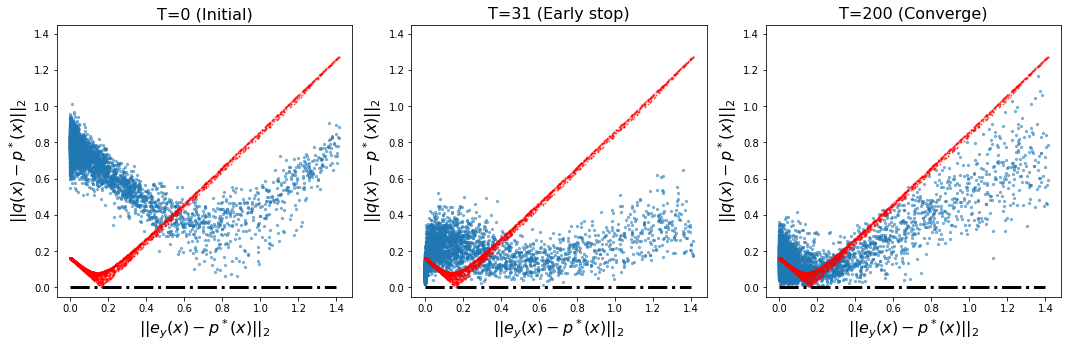

In [ ]:
figure, ax = plt.subplots(1,3,figsize=(18,5))
ax[0].scatter(hardness_x, hardness_LS_y0,s=5,alpha=0.5)
ax[0].scatter(hardness_x,hardness_LS_label,s=1,alpha=0.5,color='red')
ax[0].set_ylim(-0.05,1.45)
ax[0].plot([0,1.4],[0,0],'k-.',linewidth=3,label='GT')
ax[0].set_title('T=0 (Initial)',fontsize=16)
ax[1].scatter(hardness_x, hardness_LS_y1,s=5,alpha=0.5)
ax[1].scatter(hardness_x,hardness_LS_label,s=1,alpha=0.5,color='red')
ax[1].set_ylim(-0.05,1.45)
ax[1].plot([0,1.4],[0,0],'k-.',linewidth=3,label='GT')
ax[1].set_title('T=31 (Early stop)',fontsize=16)
ax[2].scatter(hardness_x, hardness_LS_y2,s=5,alpha=0.5)
ax[2].scatter(hardness_x,hardness_LS_label,s=1,alpha=0.5,color='red')
ax[2].set_ylim(-0.05,1.45)
ax[2].plot([0,1.4],[0,0],'k-.',linewidth=3,label='GT')
ax[2].set_title('T=200 (Converge)',fontsize=16)

for i in range(3):
  ax[i].set_ylabel('$||q(x)-p^*(x)||_2$',fontsize=16)
  ax[i].set_xlabel('$||e_{y}(x)-p^*(x)||_2$',fontsize=16)

In [ ]:
KD_model = MLP(in_dim=X_DIM).cuda()
Init_KD_model = copy.deepcopy(KD_model)
KD_optimizer = optim.SGD(KD_model.parameters(), lr=LR, momentum=0.9)
KD_scheduler = optim.lr_scheduler.CosineAnnealingLR(KD_optimizer, T_max=EPOCHS, eta_min=LR_MIN)
best_KD_model, KD_results = train(KD_model, KD_optimizer, KD_scheduler, 'from_teacher', teacher=OHT_model,prt_flag=True)

	==Training , Epoch:  20/200	Loss: 0.120575	TACC: 0.934200,	VACC:0.900600
	==Training , Epoch:  30/200	Loss: 0.086231	TACC: 0.939800,	VACC:0.901200
	==Training , Epoch:  40/200	Loss: 0.150565	TACC: 0.945400,	VACC:0.899000
	==Training , Epoch:  50/200	Loss: 0.009908	TACC: 0.954200,	VACC:0.894800
	==Training , Epoch:  60/200	Loss: 0.024911	TACC: 0.964800,	VACC:0.891400
	==Training , Epoch:  70/200	Loss: 0.080430	TACC: 0.971400,	VACC:0.890600
	==Training , Epoch:  80/200	Loss: 0.023410	TACC: 0.977200,	VACC:0.889200
	==Training , Epoch:  90/200	Loss: 0.054679	TACC: 0.984000,	VACC:0.885200
	==Training , Epoch: 100/200	Loss: 0.153386	TACC: 0.989400,	VACC:0.884000
	==Training , Epoch: 110/200	Loss: 0.021400	TACC: 0.993400,	VACC:0.882000
	==Training , Epoch: 120/200	Loss: 0.052329	TACC: 0.996000,	VACC:0.879600
	==Training , Epoch: 130/200	Loss: 0.043300	TACC: 0.998200,	VACC:0.879400
	==Training , Epoch: 140/200	Loss: 0.003356	TACC: 0.999400,	VACC:0.877400
	==Training , Epoch: 150/200	Loss: 0.0

In [ ]:
init_KD_train = get_hardness_metric(Init_KD_model,True,'model_true')
early_KD_train = get_hardness_metric(best_KD_model,True,'model_true')
converge_KD_train = get_hardness_metric(KD_model,True,'model_true')

kdlabel_true_train = get_hardness_metric(OHT_model,True,'model_true')
kdlabel_true_valid = get_hardness_metric(OHT_model,False,'model_true')

hardness_KD_label = kdlabel_true_train.sort_values('index',ascending=True)['hardness']

hardness_KD_y0 = init_KD_train.sort_values('index',ascending=True)['hardness']
hardness_KD_y1 = early_KD_train.sort_values('index',ascending=True)['hardness']
hardness_KD_y2 = converge_KD_train.sort_values('index',ascending=True)['hardness']

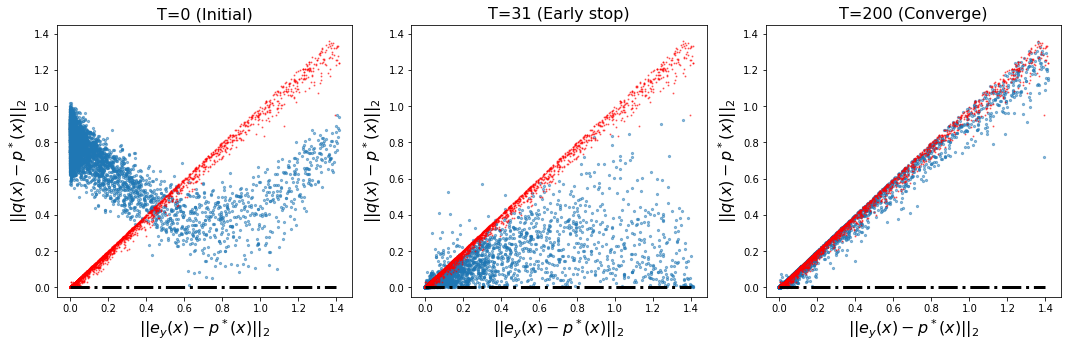

In [ ]:
figure, ax = plt.subplots(1,3,figsize=(18,5))
ax[0].scatter(hardness_x, hardness_KD_y0,s=5,alpha=0.5)
ax[0].scatter(hardness_x,hardness_KD_label,s=1,alpha=0.5,color='red')
ax[0].set_ylim(-0.05,1.45)
ax[0].plot([0,1.4],[0,0],'k-.',linewidth=3,label='GT')
ax[0].set_title('T=0 (Initial)',fontsize=16)
ax[1].scatter(hardness_x, hardness_KD_y1,s=5,alpha=0.5)
ax[1].scatter(hardness_x,hardness_KD_label,s=1,alpha=0.5,color='red')
ax[1].set_ylim(-0.05,1.45)
ax[1].plot([0,1.4],[0,0],'k-.',linewidth=3,label='GT')
ax[1].set_title('T=31 (Early stop)',fontsize=16)
ax[2].scatter(hardness_x, hardness_KD_y2,s=5,alpha=0.5)
ax[2].scatter(hardness_x,hardness_KD_label,s=1,alpha=0.5,color='red')
ax[2].set_ylim(-0.05,1.45)
ax[2].plot([0,1.4],[0,0],'k-.',linewidth=3,label='GT')
ax[2].set_title('T=200 (Converge)',fontsize=16)

for i in range(3):
  ax[i].set_ylabel('$||q(x)-p^*(x)||_2$',fontsize=16)
  ax[i].set_xlabel('$||e_{y}(x)-p^*(x)||_2$',fontsize=16)

In [ ]:
ESKD_model = MLP(in_dim=X_DIM).cuda()
Init_ESKD_model = copy.deepcopy(ESKD_model)
ESKD_optimizer = optim.SGD(ESKD_model.parameters(), lr=LR, momentum=0.9)
ESKD_scheduler = optim.lr_scheduler.CosineAnnealingLR(ESKD_optimizer, T_max=EPOCHS, eta_min=LR_MIN)
best_ESKD_model, ESKD_results = train(ESKD_model, ESKD_optimizer, ESKD_scheduler, 'from_teacher', teacher=best_OHT_model,prt_flag=True)

	==Training , Epoch:   0/200	Loss: 0.333637	TACC: 0.870600,	VACC:0.862800
	==Training , Epoch:  10/200	Loss: 0.060019	TACC: 0.917200,	VACC:0.904800
	==Training , Epoch:  20/200	Loss: 0.016063	TACC: 0.918400,	VACC:0.905800
	==Training , Epoch:  30/200	Loss: 0.026395	TACC: 0.919000,	VACC:0.906000
	==Training , Epoch:  40/200	Loss: 0.004178	TACC: 0.918400,	VACC:0.906400
	==Training , Epoch:  50/200	Loss: 0.006835	TACC: 0.918600,	VACC:0.906800
	==Training , Epoch:  60/200	Loss: 0.009980	TACC: 0.920200,	VACC:0.905600
	==Training , Epoch:  70/200	Loss: 0.002689	TACC: 0.920200,	VACC:0.905200
	==Training , Epoch:  80/200	Loss: 0.007792	TACC: 0.922400,	VACC:0.906200
	==Training , Epoch:  90/200	Loss: 0.004241	TACC: 0.921600,	VACC:0.905000
	==Training , Epoch: 100/200	Loss: 0.001863	TACC: 0.922200,	VACC:0.904800
	==Training , Epoch: 110/200	Loss: 0.003650	TACC: 0.922000,	VACC:0.903800
	==Training , Epoch: 120/200	Loss: 0.006127	TACC: 0.922200,	VACC:0.904000
	==Training , Epoch: 130/200	Loss: 0.0

In [ ]:
init_ESKD_train = get_hardness_metric(Init_ESKD_model,True,'model_true')
early_ESKD_train = get_hardness_metric(best_ESKD_model,True,'model_true')
converge_ESKD_train = get_hardness_metric(ESKD_model,True,'model_true')

eskdlabel_true_train = get_hardness_metric(best_OHT_model,True,'model_true')
eskdlabel_true_valid = get_hardness_metric(best_OHT_model,False,'model_true')

hardness_ESKD_label = eskdlabel_true_train.sort_values('index',ascending=True)['hardness']

hardness_ESKD_y0 = init_ESKD_train.sort_values('index',ascending=True)['hardness']
hardness_ESKD_y1 = early_ESKD_train.sort_values('index',ascending=True)['hardness']
hardness_ESKD_y2 = converge_ESKD_train.sort_values('index',ascending=True)['hardness']

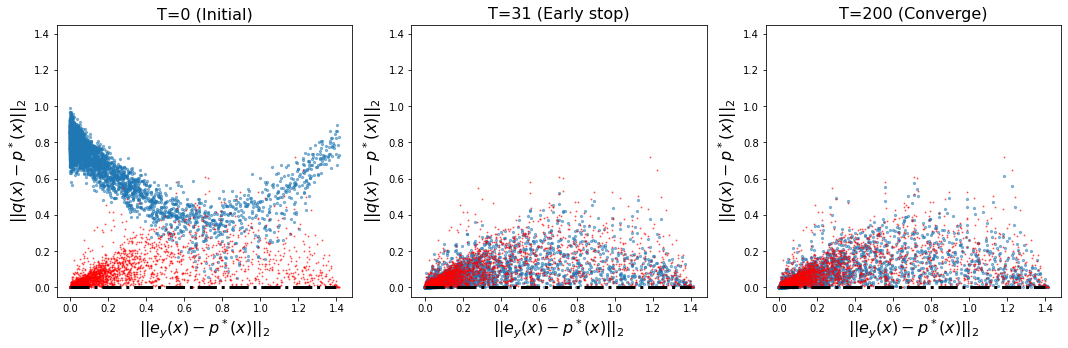

In [ ]:
figure, ax = plt.subplots(1,3,figsize=(18,5))
ax[0].scatter(hardness_x, hardness_ESKD_y0,s=5,alpha=0.5)
ax[0].scatter(hardness_x,hardness_ESKD_label,s=1,alpha=0.5,color='red')
ax[0].set_ylim(-0.05,1.45)
ax[0].plot([0,1.4],[0,0],'k-.',linewidth=3,label='GT')
ax[0].set_title('T=0 (Initial)',fontsize=16)
ax[1].scatter(hardness_x, hardness_ESKD_y1,s=5,alpha=0.5)
ax[1].scatter(hardness_x,hardness_ESKD_label,s=1,alpha=0.5,color='red')
ax[1].set_ylim(-0.05,1.45)
ax[1].plot([0,1.4],[0,0],'k-.',linewidth=3,label='GT')
ax[1].set_title('T=31 (Early stop)',fontsize=16)
ax[2].scatter(hardness_x, hardness_ESKD_y2,s=5,alpha=0.5)
ax[2].scatter(hardness_x,hardness_ESKD_label,s=1,alpha=0.5,color='red')
ax[2].set_ylim(-0.05,1.45)
ax[2].plot([0,1.4],[0,0],'k-.',linewidth=3,label='GT')
ax[2].set_title('T=200 (Converge)',fontsize=16)

for i in range(3):
  ax[i].set_ylabel('$||q(x)-p^*(x)||_2$',fontsize=16)
  ax[i].set_xlabel('$||e_{y}(x)-p^*(x)||_2$',fontsize=16)

In [ ]:
GT_model = MLP(in_dim=X_DIM).cuda()
Init_GT_model = copy.deepcopy(GT_model)
GT_optimizer = optim.SGD(GT_model.parameters(), lr=LR, momentum=0.9)
GT_scheduler = optim.lr_scheduler.CosineAnnealingLR(GT_optimizer, T_max=EPOCHS, eta_min=LR_MIN)
best_GT_model, GT_results = train(GT_model, GT_optimizer, GT_scheduler, 'from_gt',prt_flag=True)

	==Training , Epoch:   0/200	Loss: 0.280714	TACC: 0.872000,	VACC:0.868600
	==Training , Epoch:  10/200	Loss: 0.015092	TACC: 0.910200,	VACC:0.905000
	==Training , Epoch:  20/200	Loss: 0.006040	TACC: 0.911800,	VACC:0.907000
	==Training , Epoch:  30/200	Loss: 0.003808	TACC: 0.913000,	VACC:0.906600
	==Training , Epoch:  40/200	Loss: 0.006335	TACC: 0.913200,	VACC:0.907000
	==Training , Epoch:  50/200	Loss: 0.002780	TACC: 0.913400,	VACC:0.907000
	==Training , Epoch:  60/200	Loss: 0.002723	TACC: 0.914400,	VACC:0.907000
	==Training , Epoch:  70/200	Loss: 0.004512	TACC: 0.914600,	VACC:0.907000
	==Training , Epoch:  80/200	Loss: 0.005284	TACC: 0.914000,	VACC:0.907400
	==Training , Epoch:  90/200	Loss: 0.000946	TACC: 0.914000,	VACC:0.907000
	==Training , Epoch: 100/200	Loss: 0.000764	TACC: 0.913400,	VACC:0.907200
	==Training , Epoch: 110/200	Loss: 0.001133	TACC: 0.913800,	VACC:0.907800
	==Training , Epoch: 120/200	Loss: 0.001835	TACC: 0.914400,	VACC:0.907400
	==Training , Epoch: 130/200	Loss: 0.0

In [ ]:
init_GT_train = get_hardness_metric(Init_GT_model,True,'model_true')
early_GT_train = get_hardness_metric(best_GT_model,True,'model_true')
converge_GT_train = get_hardness_metric(GT_model,True,'model_true')

hardness_GT_y0 = init_GT_train.sort_values('index',ascending=True)['hardness']
hardness_GT_y1 = early_GT_train.sort_values('index',ascending=True)['hardness']
hardness_GT_y2 = converge_GT_train.sort_values('index',ascending=True)['hardness']

In [ ]:
figure, ax = plt.subplots(1,3,figsize=(18,5))
ax[0].scatter(hardness_x, hardness_GT_y0,s=5,alpha=0.5)
ax[0].plot([0,1.4],[0,0],'r-',linewidth=3,label='GT')
ax[0].set_ylim(-0.05,1.45)
ax[0].set_title('Initial',fontsize=16)
ax[1].scatter(hardness_x, hardness_GT_y1,s=5,alpha=0.5)
ax[1].plot([0,1.4],[0,0],'r-',linewidth=3,label='GT')
ax[1].set_ylim(-0.05,1.45)
ax[1].set_title('Early stop',fontsize=16)
ax[2].scatter(hardness_x, hardness_GT_y2,s=5,alpha=0.5)
ax[2].plot([0,1.4],[0,0],'r-',linewidth=3,label='GT')
ax[2].set_ylim(-0.05,1.45)
ax[2].set_title('Converge',fontsize=16)

for i in range(3):
  ax[i].set_ylabel('$||q(x)-p^*(x)||_2$',fontsize=16)
  ax[i].set_xlabel('$||e_{y}(x)-p^*(x)||_2$',fontsize=16)

## Select 100 hard/medium/easy samples and see the learning path in finer granularity



In [ ]:
HARD100 = oht_true_train[50:150]
MEDI100 = oht_true_train[800:900]
EASY100 = oht_true_train[3000:3100]

HARD100_IDX = np.array(HARD100['index']).astype(int)
MEDI100_IDX = np.array(MEDI100['index']).astype(int)
EASY100_IDX = np.array(EASY100['index']).astype(int)

HARD100_X, HARD100_Y, HARD100_P = torch.tensor(x_true[HARD100_IDX]), y_true[HARD100_IDX], p_true[HARD100_IDX]
MEDI100_X, MEDI100_Y, MEDI100_P = torch.tensor(x_true[MEDI100_IDX]), y_true[MEDI100_IDX], p_true[MEDI100_IDX]
EASY100_X, EASY100_Y, EASY100_P = torch.tensor(x_true[EASY100_IDX]), y_true[EASY100_IDX], p_true[EASY100_IDX]

fine_path_length = int(N_Train/BATCH_SIZE)*EPOCHS

In [ ]:
def _Gen_record100_Path(model, cnt, hardness='hard'):
  model.eval()
  
  if hardness == 'hard':
    store_table = FINE_PATH_TRAIN_HARD
    data = HARD100_X
  elif hardness == 'medi':
    store_table = FINE_PATH_TRAIN_MEDI
    data = MEDI100_X
  elif hardness == 'easy':
    store_table = FINE_PATH_TRAIN_EASY
    data = EASY100_X
  data = data.float().cuda()
  with torch.no_grad():
    hid = model(data)
    prob = F.softmax(hid,1)
    store_table[:,cnt,:] = prob.cpu().numpy()
  model.train()

def get_path(model, optimizer, scheduler, loss_type='from_oht', teacher=None, prt_flag=False):
  results = {'loss':[]}
  model.train()
  cnt = 0
  for g in range(EPOCHS):
    for x,y,p,idx in train_loader:
      x,y,p = x.float().cuda(), y.long().cuda(), p.float().cuda()
      optimizer.zero_grad()
      hid = model(x)
      _Gen_record100_Path(model, cnt, hardness='hard')
      _Gen_record100_Path(model, cnt, hardness='medi')
      _Gen_record100_Path(model, cnt, hardness='easy')
      if loss_type == 'from_oht':
        p_tgt = _y_to_oht(y)
      elif loss_type == 'from_ls':
        p_tgt = _y_to_smoothed(y)
      elif loss_type == 'from_gt':
        p_tgt = p
      elif loss_type == 'from_teacher':
        teacher.eval()
        hid_teach = teacher(x)
        hid_teach = hid_teach.detach()
        p_tgt = F.softmax(hid_teach,1)
      loss = cal_entropy(hid, p_tgt)
      loss.backward()
      optimizer.step()
      results['loss'].append(loss.item())
      cnt += 1
    scheduler.step()
    if prt_flag and g%10==0:
      print('\t==Training , Epoch: {:3d}/{:3d}\tLoss is {:.6f}'.format(g,EPOCHS, results['loss'][-1]))

In [ ]:
FINE_PATH_TRAIN_HARD = np.zeros((100,fine_path_length,K_CLAS))
FINE_PATH_TRAIN_MEDI = np.zeros((100,fine_path_length,K_CLAS))
FINE_PATH_TRAIN_EASY = np.zeros((100,fine_path_length,K_CLAS))

path_model = MLP(in_dim=X_DIM).cuda()
path_optimizer = optim.SGD(path_model.parameters(), lr=LR, momentum=0.9)
path_scheduler = optim.lr_scheduler.CosineAnnealingLR(path_optimizer, T_max=EPOCHS, eta_min=LR_MIN)
get_path(path_model, path_optimizer, path_scheduler, 'from_oht',prt_flag=True)

	==Training , Epoch:   0/200	Loss is 0.628274
	==Training , Epoch:  10/200	Loss is 0.149443
	==Training , Epoch:  20/200	Loss is 0.056987
	==Training , Epoch:  30/200	Loss is 0.135657
	==Training , Epoch:  40/200	Loss is 0.189460
	==Training , Epoch:  50/200	Loss is 0.255003
	==Training , Epoch:  60/200	Loss is 0.081565
	==Training , Epoch:  70/200	Loss is 0.222410
	==Training , Epoch:  80/200	Loss is 0.006472
	==Training , Epoch:  90/200	Loss is 0.117937
	==Training , Epoch: 100/200	Loss is 0.021953
	==Training , Epoch: 110/200	Loss is 0.001466
	==Training , Epoch: 120/200	Loss is 0.012060
	==Training , Epoch: 130/200	Loss is 0.031622
	==Training , Epoch: 140/200	Loss is 0.036332
	==Training , Epoch: 150/200	Loss is 0.018800
	==Training , Epoch: 160/200	Loss is 0.000095
	==Training , Epoch: 170/200	Loss is 0.014473
	==Training , Epoch: 180/200	Loss is 0.007098
	==Training , Epoch: 190/200	Loss is 0.020143


## Show the learning path of one sample

In [ ]:
# ============ Necessary functions ==========
def p_to_xy(p,corners):
  # ==== p must have shape (x,3) =====
  x = p[:,0]*corners[0,0]+p[:,1]*corners[1,0]+p[:,2]*corners[2,0]
  y = p[:,0]*corners[0,1]+p[:,1]*corners[1,1]+p[:,2]*corners[2,1]
  return torch.stack((x.unsqueeze(1),y.unsqueeze(1)),dim=1).squeeze()

def p_to_xy_path(p,corners):
  # ==== p must have shape (id,x,3) =====
  x = p[:,:,0]*corners[0,0]+p[:,:,1]*corners[1,0]+p[:,:,2]*corners[2,0]
  y = p[:,:,0]*corners[0,1]+p[:,:,1]*corners[1,1]+p[:,:,2]*corners[2,1]
  return torch.stack((x.unsqueeze(1),y.unsqueeze(1)),dim=-1).squeeze()

corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
AREA = 0.5 * 1 * 0.75**0.5
triangle = tri.Triangulation(corners[:, 0], corners[:, 1])
def smooth_path(origin_path, alpha=0.9):
    for i in range(origin_path.shape[1]):
        if i==0:
            smooth_path = origin_path[:,0,:].unsqueeze(1)
            previous = smooth_path
        else:
            tmp = origin_path[:,i,:].unsqueeze(1)*(1-alpha) + previous*alpha
            smooth_path = torch.cat((smooth_path,tmp),dim=1)
            previous = tmp
    return smooth_path
'''
def draw_path_coarse(path_id, smooth_level=0.9,highlight_ep=50, start_end=[0,EPOCHS], 
                       train=True,ax=None,legend=True):
    '''
        Only works for train path and test path with correct predictions
    '''
    if ax is None:
        figure, ax = plt.subplots(1,1,figsize=(5,5))
    if train:
        origin_path = PATH_DICT_TRAIN[path_id,:,:]
        y_star = p_to_xy_path(y_to_oht(torch.tensor(y_true[path_id]).unsqueeze(0).long()).unsqueeze(0),corners)
        p_star = p_to_xy_path(p_true[path_id].unsqueeze(0).unsqueeze(0),corners)
    else:
        origin_path = PATH_DICT_VALID[path_id,:,:]
        y_star = p_to_xy_path(y_to_oht(torch.tensor(y_true[path_id+N_Train]).unsqueeze(0).long()).unsqueeze(0),corners)
        p_star = p_to_xy_path(p_true[path_id+N_Train].unsqueeze(0).unsqueeze(0),corners)
    start_ep, end_ep = start_end[0], start_end[1]
    merged_path = np.zeros((origin_path.shape[0],3))

    merged_path[:,0] = origin_path[:,0]
    merged_path[:,1] = origin_path[:,1]
    merged_path[:,2] = np.ones(origin_path.shape[0])-origin_path[:,0]-origin_path[:,1]
    merged_path = torch.tensor(merged_path).unsqueeze(0)

    merged_path_smth = smooth_path(merged_path,smooth_level)
    path_to_draw = p_to_xy_path(merged_path,corners)
    path_to_draw_smth = p_to_xy_path(merged_path_smth,corners)

    highlight_idx = highlight_ep
    colors = range(end_ep-start_ep)
    ax.triplot(triangle)
    ax.axis('off')
    ax.axis('equal')

    ax.scatter(path_to_draw[start_ep:end_ep,0],path_to_draw[start_ep:end_ep,1],c=colors,cmap=plt.cm.Blues, edgecolors='none', s=40,alpha=0.8)
    ax.scatter(path_to_draw[end_ep:,0],path_to_draw[end_ep:,1],color='midnightblue', edgecolors='none', s=40,alpha=0.4)
    ax.scatter(path_to_draw[0,0],path_to_draw[0,1], color='blue',label='Origin Path',s=60,alpha=0.5)
    ax.scatter(y_star[0],y_star[1],color='red',label='OHT Label',s=150,alpha=0.8,marker='X')
    ax.scatter(p_star[0],p_star[1],color='grey',label='p* Label',s=150,alpha=0.8,marker='X')
    ax.scatter(path_to_draw[0,0],path_to_draw[0,1], color='green',label='Start',s=100,alpha=0.8,marker='D')
    ax.scatter(path_to_draw_smth[highlight_idx,0],path_to_draw_smth[highlight_idx,1], color='red',label='Early Stopped',s=300,alpha=0.8,marker='+')
    if smooth_level!=0:
      ax.scatter(path_to_draw[0,0],path_to_draw[0,1], color='red',label='Smoothed Path',s=60,alpha=0.5)
      ax.scatter(path_to_draw_smth[start_ep:end_ep,0],path_to_draw_smth[start_ep:end_ep,1],c=colors,cmap=plt.cm.Reds, edgecolors='none', s=40,alpha=0.8)
      ax.scatter(path_to_draw_smth[end_ep:,0],path_to_draw_smth[end_ep:,1],color='darkred', edgecolors='none', s=40,alpha=0.2)
    if legend:
      ax.legend() 
'''

def draw_path_fine(path_id, smooth_level=0.9,highlight_ep=50, start_end=[0,10000], down_sample=10, 
                       hardness='hard',ax=None,legend=True):
    '''
        Only works for train path and test path with correct predictions
    '''
    if ax is None:
      figure, ax = plt.subplots(1,1,figsize=(5,5))
    if hardness=='hard':
      origin_path = FINE_PATH_TRAIN_HARD[path_id,::down_sample,:]
      y_star = p_to_xy_path(y_to_oht(torch.tensor(HARD100_Y[path_id]).unsqueeze(0).long()).unsqueeze(0),corners)
      p_star = p_to_xy_path(HARD100_P[path_id].unsqueeze(0).unsqueeze(0),corners)
    elif hardness=='medi':
      origin_path = FINE_PATH_TRAIN_MEDI[path_id,::down_sample,:]
      y_star = p_to_xy_path(y_to_oht(torch.tensor(MEDI100_Y[path_id]).unsqueeze(0).long()).unsqueeze(0),corners)
      p_star = p_to_xy_path(MEDI100_P[path_id].unsqueeze(0).unsqueeze(0),corners)   
    elif hardness=='easy':
      origin_path = FINE_PATH_TRAIN_EASY[path_id,::down_sample,:]
      y_star = p_to_xy_path(y_to_oht(torch.tensor(EASY100_Y[path_id]).unsqueeze(0).long()).unsqueeze(0),corners)
      p_star = p_to_xy_path(EASY100_P[path_id].unsqueeze(0).unsqueeze(0),corners)   

    start_ep, end_ep = start_end[0], start_end[1]
    merged_path = np.zeros((origin_path.shape[0],3))

    merged_path[:,0] = origin_path[:,0]
    merged_path[:,1] = origin_path[:,1]
    merged_path[:,2] = np.ones(origin_path.shape[0])-origin_path[:,0]-origin_path[:,1]
    merged_path = torch.tensor(merged_path).unsqueeze(0)

    merged_path_smth = smooth_path(merged_path,smooth_level)
    path_to_draw = p_to_xy_path(merged_path,corners)
    path_to_draw_smth = p_to_xy_path(merged_path_smth,corners)

    highlight_idx = int(highlight_ep*N_Train/(BATCH_SIZE*down_sample))-1
    colors = range(end_ep-start_ep)
    ax.triplot(triangle)
    ax.axis('off')
    ax.axis('equal')

    ax.scatter(path_to_draw[start_ep:end_ep,0],path_to_draw[start_ep:end_ep,1],c=colors,cmap=plt.cm.Blues, edgecolors='none', s=40,alpha=0.8)
    ax.scatter(path_to_draw[end_ep:,0],path_to_draw[end_ep:,1],color='midnightblue', edgecolors='none', s=40,alpha=0.4)
    ax.scatter(path_to_draw[0,0],path_to_draw[0,1], color='blue',label='Origin Path',s=60,alpha=0.5)
    ax.scatter(y_star[0],y_star[1],color='red',label='OHT Label',s=250,alpha=0.8,marker='X')
    ax.scatter(p_star[0],p_star[1],color='grey',label='p* Label',s=250,alpha=0.8,marker='X')
    ax.scatter(path_to_draw[0,0],path_to_draw[0,1], color='green',label='Start',s=100,alpha=0.8,marker='D')
    ax.scatter(path_to_draw_smth[highlight_idx,0],path_to_draw_smth[highlight_idx,1], color='red',label='Early Stopped',s=300,alpha=0.8,marker='+')
    if smooth_level!=0:
      ax.scatter(path_to_draw_smth[start_ep:end_ep,0],path_to_draw_smth[start_ep:end_ep,1],c=colors,cmap=plt.cm.Reds, edgecolors='none', s=40,alpha=0.8)
      ax.scatter(path_to_draw[0,0],path_to_draw[0,1], color='red',label='Smoothed Path',s=60,alpha=0.5)
    if legend:
        ax.legend(fontsize=14) 


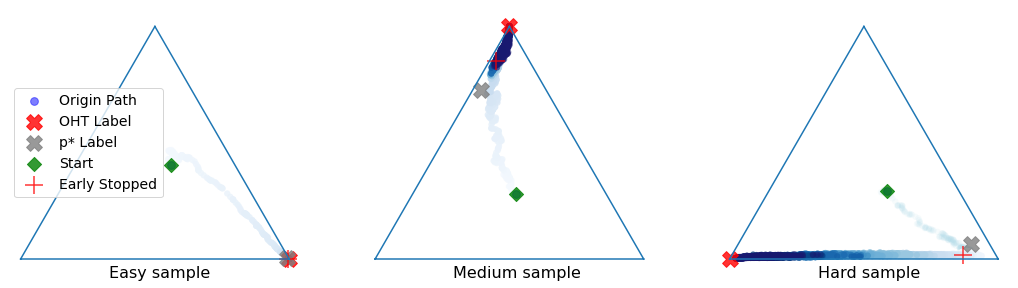

In [ ]:
# As the network might already converged at the 5000th update, we draw 1-1000 updates for medium and easy samples
figure_path, ax_path = plt.subplots(1,3,figsize=(18,5))
draw_path_fine(17, smooth_level=0,highlight_ep=OHT_results['IDX_MAX'], start_end=[0,5000],down_sample=10, hardness='hard',ax=ax_path[2],legend=False)
draw_path_fine(8, smooth_level=0,highlight_ep=OHT_results['IDX_MAX'], start_end=[0,1000],down_sample=10, hardness='medi',ax=ax_path[1],legend=False)
draw_path_fine(8, smooth_level=0,highlight_ep=OHT_results['IDX_MAX'], start_end=[0,1000],down_sample=10, hardness='easy',ax=ax_path[0],legend=True)
ax_path[2].text(0.33,-0.07,'Hard sample',fontsize=16)
ax_path[1].text(0.29,-0.07,'Medium sample',fontsize=16)
ax_path[0].text(0.33,-0.07,'Easy sample',fontsize=16)

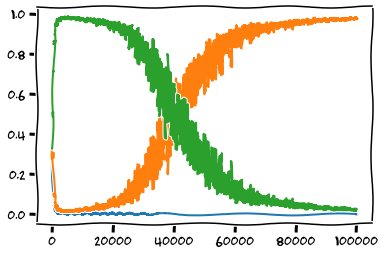

In [ ]:
path_id = 1
FINE_PATH = FINE_PATH_TRAIN_HARD
with plt.xkcd():
  plt.figure(1)
  for i in range(3):
    plt.plot(FINE_PATH[path_id,:,i])